Experiment E1-7:
- binary classification
- dataset train 3500, val 1500
- BATCH_SIZE = 20
- IMAGE_SIZE = 256
- EPOCHS = 30
- criterion = nn.BCEWithLogitsLoss()
- optimizer = Adam
- lr=5e-6

model:
- self.base_model(x)
- unfreeze 3 layers
- self.globalavg(x) # (2,2)
- self.flatten(x)
- self.fc(x) # (5120,512)->Dropout(0.5)->Relu->(512,1)

In [1]:
import numpy as np
import os
import sys
import glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms, models
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from PIL import Image

In [2]:
# load common py
sys.path.append('../src')
import config
import common_utils
import data_utils
import train_utils
import plot_utils


In [3]:
# override config for experiment
EXP_CODE = "E1-7"
SAVE_FILENAME = f"stage1-{EXP_CODE}-metrics"

config.EPOCHS = 30
config.LEARNING_RATE = 5e-6

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

common_utils.set_seed(config.SEED)


In [5]:
df = pd.read_csv(config.TRAIN_CSV)

In [6]:
# split data into train, val, test 70/15/15
# for fast training, use only 3500 and 1500 samples for train and val

train_df, val_df, test_df, train_small_df, val_small_df = data_utils.split_data(df, config.SEED, small_train_size=3500, small_val_size=1500)

In [7]:
# create transforms
train_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [8]:
# create datasets
train_small_dataset = data_utils.SteelDataset(df=train_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=train_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                    )
val_small_dataset = data_utils.SteelDataset(df=val_small_df, 
                                    data_folder=config.IMAGE_FOLDER,
                                    transforms=test_val_transform,
                                    image_size=config.IMAGE_SIZE,
                                    return_tensor=True
                                   )


In [9]:
train_small_loader = DataLoader(train_small_dataset, batch_size=config.BATCH_SIZE,
                          shuffle=True,
                          num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                          )

val_small_loader = DataLoader(val_small_dataset, batch_size=config.BATCH_SIZE,
                         shuffle=False,
                         num_workers=config.NUM_WORKERS, pin_memory=True, persistent_workers=True, prefetch_factor=config.PREFETCH_FACTOR
                         )


In [10]:
# create model
class SteelModel(nn.Module):
    def __init__(self):
        super(SteelModel, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1').features
        for param in self.base_model.parameters():
            param.requires_grad = False

        for p in self.base_model[-3:].parameters():
            p.requires_grad = True

        # Remove original classifier
        #self.base_model.classifier = nn.Identity()

        self.globalavg = nn.AdaptiveAvgPool2d((2, 2))

        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(1280 * 2 * 2, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 1),
        )
               

    def forward(self, x):
        x = self.base_model(x)
        #print(x.shape)
        x = self.globalavg(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x 

In [11]:
model = SteelModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [12]:
%%time

arr_train_acc = []
arr_train_loss = []
arr_train_precision = []
arr_train_recall = []
arr_train_f1 = []
arr_train_rocauc = []
arr_train_conf_matrix = []

arr_val_acc = []
arr_val_loss = []
arr_val_precision = []
arr_val_recall = []
arr_val_f1 = []
arr_val_rocauc = []
arr_val_conf_matrix = []

idx = 0
for epoch in range(config.EPOCHS):
    train_loss, train_all_labels, train_all_preds, train_all_probs = train_utils.train_one_epoch(model, train_small_loader, criterion, optimizer, device)
    val_loss, val_all_labels, val_all_preds, val_all_probs = train_utils.validate_one_epoch(model, val_small_loader, criterion, device)

    # train metrics
    train_accuracy = (train_all_preds == train_all_labels).mean()
    train_precision = precision_score(train_all_labels, train_all_preds)
    train_recall = recall_score(train_all_labels, train_all_preds)
    train_f1 = f1_score(train_all_labels, train_all_preds)
    train_rocauc = roc_auc_score(train_all_labels, train_all_probs)
    train_conf_matrix = confusion_matrix(train_all_labels, train_all_preds)
    train_tn, train_fp, train_fn, train_tp = train_conf_matrix.ravel()
    
    arr_train_loss.append(train_loss)
    arr_train_acc.append(train_accuracy)
    arr_train_precision.append(train_precision)
    arr_train_recall.append(train_recall)
    arr_train_f1.append(train_f1)
    arr_train_rocauc.append(train_rocauc)
    arr_train_conf_matrix.append({'tn': train_tn, 'fp': train_fp, 'fn': train_fn, 'tp': train_tp})

    # val metrics
    val_accuracy = (val_all_preds == val_all_labels).mean()
    val_precision = precision_score(val_all_labels, val_all_preds)
    val_recall = recall_score(val_all_labels, val_all_preds)
    val_f1 = f1_score(val_all_labels, val_all_preds)
    val_rocauc = roc_auc_score(val_all_labels, val_all_probs)
    val_conf_matrix = confusion_matrix(val_all_labels, val_all_preds)
    val_tn, val_fp, val_fn, val_tp = val_conf_matrix.ravel()

    arr_val_loss.append(val_loss)
    arr_val_acc.append(val_accuracy)
    arr_val_precision.append(val_precision)
    arr_val_recall.append(val_recall)
    arr_val_f1.append(val_f1)
    arr_val_rocauc.append(val_rocauc)
    arr_val_conf_matrix.append({'tn': val_tn, 'fp': val_fp, 'fn': val_fn, 'tp': val_tp})

    print(idx+1)
    print(f"Epoch {epoch+1}/{config.EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"  Train Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | F1: {train_f1:.4f} | ROC AUC: {train_rocauc:.4f}")
    print(f"  Train Confusion Matrix: TN={train_tn}, FP={train_fp}, FN={train_fn}, TP={train_tp}")
    print(f"  Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f} | ROC AUC: {val_rocauc:.4f}")
    print(f"  Val Confusion Matrix: TN={val_tn}, FP={val_fp}, FN={val_fn}, TP={val_tp}")

    idx += 1
    #break


1
Epoch 1/30
  Train Loss: 0.6254 | Train Acc: 0.6643
  Val Loss  : 0.5501 | Val Acc: 0.7560
  Train Precision: 0.6461 | Recall: 0.8514 | F1: 0.7347 | ROC AUC: 0.7328
  Train Confusion Matrix: TN=698, FP=891, FN=284, TP=1627
  Val Precision: 0.7127 | Recall: 0.9267 | F1: 0.8057 | ROC AUC: 0.8667
  Val Confusion Matrix: TN=375, FP=306, FN=60, TP=759
2
Epoch 2/30
  Train Loss: 0.5105 | Train Acc: 0.7734
  Val Loss  : 0.4571 | Val Acc: 0.8180
  Train Precision: 0.7518 | Recall: 0.8734 | F1: 0.8080 | ROC AUC: 0.8602
  Train Confusion Matrix: TN=1038, FP=551, FN=242, TP=1669
  Val Precision: 0.8438 | Recall: 0.8181 | F1: 0.8308 | ROC AUC: 0.8963
  Val Confusion Matrix: TN=557, FP=124, FN=149, TP=670
3
Epoch 3/30
  Train Loss: 0.4284 | Train Acc: 0.8200
  Val Loss  : 0.3943 | Val Acc: 0.8380
  Train Precision: 0.8169 | Recall: 0.8639 | F1: 0.8398 | ROC AUC: 0.8995
  Train Confusion Matrix: TN=1219, FP=370, FN=260, TP=1651
  Val Precision: 0.8445 | Recall: 0.8620 | F1: 0.8532 | ROC AUC: 0.919

In [13]:
df_metrics = train_utils.build_metric_df(
    arr_train_loss, arr_train_acc, arr_train_precision, arr_train_recall, 
    arr_train_f1, arr_train_rocauc, arr_train_conf_matrix,
    arr_val_loss, arr_val_acc, arr_val_precision, arr_val_recall, 
    arr_val_f1, arr_val_rocauc, arr_val_conf_matrix
)


In [14]:
df_metrics

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,train_conf_matrix,val_loss,val_acc,val_precision,...,val_rocauc,val_conf_matrix,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
0,0.625449,0.664286,0.646148,0.851387,0.734703,0.732761,"{'tn': 698, 'fp': 891, 'fn': 284, 'tp': 1627}",0.550074,0.756000,0.712676,...,0.866701,"{'tn': 375, 'fp': 306, 'fn': 60, 'tp': 759}",698,891,284,1627,375,306,60,759
1,0.510508,0.773429,0.751802,0.873365,0.808037,0.860231,"{'tn': 1038, 'fp': 551, 'fn': 242, 'tp': 1669}",0.457131,0.818000,0.843829,...,0.896276,"{'tn': 557, 'fp': 124, 'fn': 149, 'tp': 670}",1038,551,242,1669,557,124,149,670
2,0.428396,0.820000,0.816922,0.863946,0.839776,0.899463,"{'tn': 1219, 'fp': 370, 'fn': 260, 'tp': 1651}",0.394274,0.838000,0.844498,...,0.919425,"{'tn': 551, 'fp': 130, 'fn': 113, 'tp': 706}",1219,370,260,1651,551,130,113,706
3,0.373514,0.842857,0.841103,0.878074,0.859191,0.923409,"{'tn': 1272, 'fp': 317, 'fn': 233, 'tp': 1678}",0.351696,0.856000,0.868132,...,0.931124,"{'tn': 573, 'fp': 108, 'fn': 108, 'tp': 711}",1272,317,233,1678,573,108,108,711
4,0.338912,0.854857,0.859191,0.878074,0.868530,0.934898,"{'tn': 1314, 'fp': 275, 'fn': 233, 'tp': 1678}",0.328508,0.860667,0.884131,...,0.938120,"{'tn': 589, 'fp': 92, 'fn': 117, 'tp': 702}",1314,275,233,1678,589,92,117,702
5,0.316937,0.865429,0.869990,0.885924,0.877884,0.941729,"{'tn': 1336, 'fp': 253, 'fn': 218, 'tp': 1693}",0.311329,0.867333,0.869048,...,0.942816,"{'tn': 571, 'fp': 110, 'fn': 89, 'tp': 730}",1336,253,218,1693,571,110,89,730
6,0.293191,0.875429,0.883915,0.888540,0.886221,0.950131,"{'tn': 1366, 'fp': 223, 'fn': 213, 'tp': 1698}",0.304246,0.872000,0.905563,...,0.945555,"{'tn': 608, 'fp': 73, 'fn': 119, 'tp': 700}",1366,223,213,1698,608,73,119,700
7,0.283194,0.882286,0.890161,0.894819,0.892484,0.953666,"{'tn': 1378, 'fp': 211, 'fn': 201, 'tp': 1710}",0.297552,0.868667,0.904948,...,0.947637,"{'tn': 608, 'fp': 73, 'fn': 124, 'tp': 695}",1378,211,201,1710,608,73,124,695
8,0.269733,0.889714,0.900683,0.896913,0.898794,0.957713,"{'tn': 1400, 'fp': 189, 'fn': 197, 'tp': 1714}",0.285728,0.876667,0.899244,...,0.950511,"{'tn': 601, 'fp': 80, 'fn': 105, 'tp': 714}",1400,189,197,1714,601,80,105,714
9,0.259695,0.893429,0.894764,0.912088,0.903343,0.960564,"{'tn': 1384, 'fp': 205, 'fn': 168, 'tp': 1743}",0.280605,0.875333,0.901015,...,0.952397,"{'tn': 603, 'fp': 78, 'fn': 109, 'tp': 710}",1384,205,168,1743,603,78,109,710


In [15]:
print('Val Metrics:')
print(df_metrics[config.VAL_METRICS])
print('')
print('Val Confusion Matrix:')
print(df_metrics[config.VAL_CF])

Val Metrics:
    val_loss   val_acc  val_precision  val_recall    val_f1  val_rocauc
0   0.550074  0.756000       0.712676    0.926740  0.805732    0.866701
1   0.457131  0.818000       0.843829    0.818071  0.830750    0.896276
2   0.394274  0.838000       0.844498    0.862027  0.853172    0.919425
3   0.351696  0.856000       0.868132    0.868132  0.868132    0.931124
4   0.328508  0.860667       0.884131    0.857143  0.870428    0.938120
5   0.311329  0.867333       0.869048    0.891331  0.880048    0.942816
6   0.304246  0.872000       0.905563    0.854701  0.879397    0.945555
7   0.297552  0.868667       0.904948    0.848596  0.875866    0.947637
8   0.285728  0.876667       0.899244    0.871795  0.885307    0.950511
9   0.280605  0.875333       0.901015    0.866911  0.883634    0.952397
10  0.272448  0.878000       0.887805    0.888889  0.888347    0.953918
11  0.267832  0.885333       0.890229    0.901099  0.895631    0.955664
12  0.272814  0.886667       0.879532    0.918193  

In [16]:
df_metrics.describe()

,train_loss,train_acc,train_precision,train_recall,train_f1,train_rocauc,val_loss,val_acc,val_precision,val_recall,val_f1,val_rocauc,train_tn,train_fp,train_fn,train_tp,val_tn,val_fp,val_fn,val_tp
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.241261,0.900448,0.902289,0.921594,0.911266,0.957973,0.290327,0.876711,0.891056,0.884778,0.887249,0.949907,1390.400000,198.600000,149.833333,1761.166667,590.433333,90.566667,94.366667,724.633333
std,0.117777,0.062000,0.066749,0.032067,0.049995,0.051798,0.068252,0.029359,0.039277,0.022679,0.023024,0.021753,164.481128,164.481128,61.280634,61.280634,44.337019,44.337019,18.574145,18.574145
min,0.124923,0.664286,0.646148,0.851387,0.734703,0.732761,0.243343,0.756000,0.712676,0.818071,0.805732,0.866701,698.000000,85.000000,77.000000,1627.000000,375.000000,59.000000,60.000000,670.000000
25%,0.156524,0.884143,0.891312,0.895343,0.894062,0.954678,0.253774,0.872833,0.888411,0.873016,0.880945,0.948355,1379.500000,110.250000,100.250000,1711.000000,589.250000,71.500000,83.250000,715.000000
50%,0.204743,0.921143,0.922714,0.933281,0.928350,0.975635,0.263528,0.886667,0.900130,0.887668,0.895986,0.956966,1440.000000,149.000000,127.500000,1783.500000,601.500000,79.500000,92.000000,727.000000
75%,0.279829,0.941500,0.943014,0.947541,0.946440,0.986062,0.294596,0.892333,0.910960,0.898352,0.900374,0.962457,1478.750000,209.500000,200.000000,1810.750000,609.500000,91.750000,104.000000,735.750000
max,0.625449,0.952000,0.955334,0.959707,0.956136,0.991467,0.550074,0.902000,0.924165,0.926740,0.910202,0.964959,1504.000000,891.000000,284.000000,1834.000000,622.000000,306.000000,149.000000,759.000000


In [17]:
print(df_metrics.describe())

       train_loss  train_acc  train_precision  train_recall   train_f1  \
count   30.000000  30.000000        30.000000     30.000000  30.000000   
mean     0.241261   0.900448         0.902289      0.921594   0.911266   
std      0.117777   0.062000         0.066749      0.032067   0.049995   
min      0.124923   0.664286         0.646148      0.851387   0.734703   
25%      0.156524   0.884143         0.891312      0.895343   0.894062   
50%      0.204743   0.921143         0.922714      0.933281   0.928350   
75%      0.279829   0.941500         0.943014      0.947541   0.946440   
max      0.625449   0.952000         0.955334      0.959707   0.956136   

       train_rocauc   val_loss    val_acc  val_precision  val_recall  \
count     30.000000  30.000000  30.000000      30.000000   30.000000   
mean       0.957973   0.290327   0.876711       0.891056    0.884778   
std        0.051798   0.068252   0.029359       0.039277    0.022679   
min        0.732761   0.243343   0.756000    

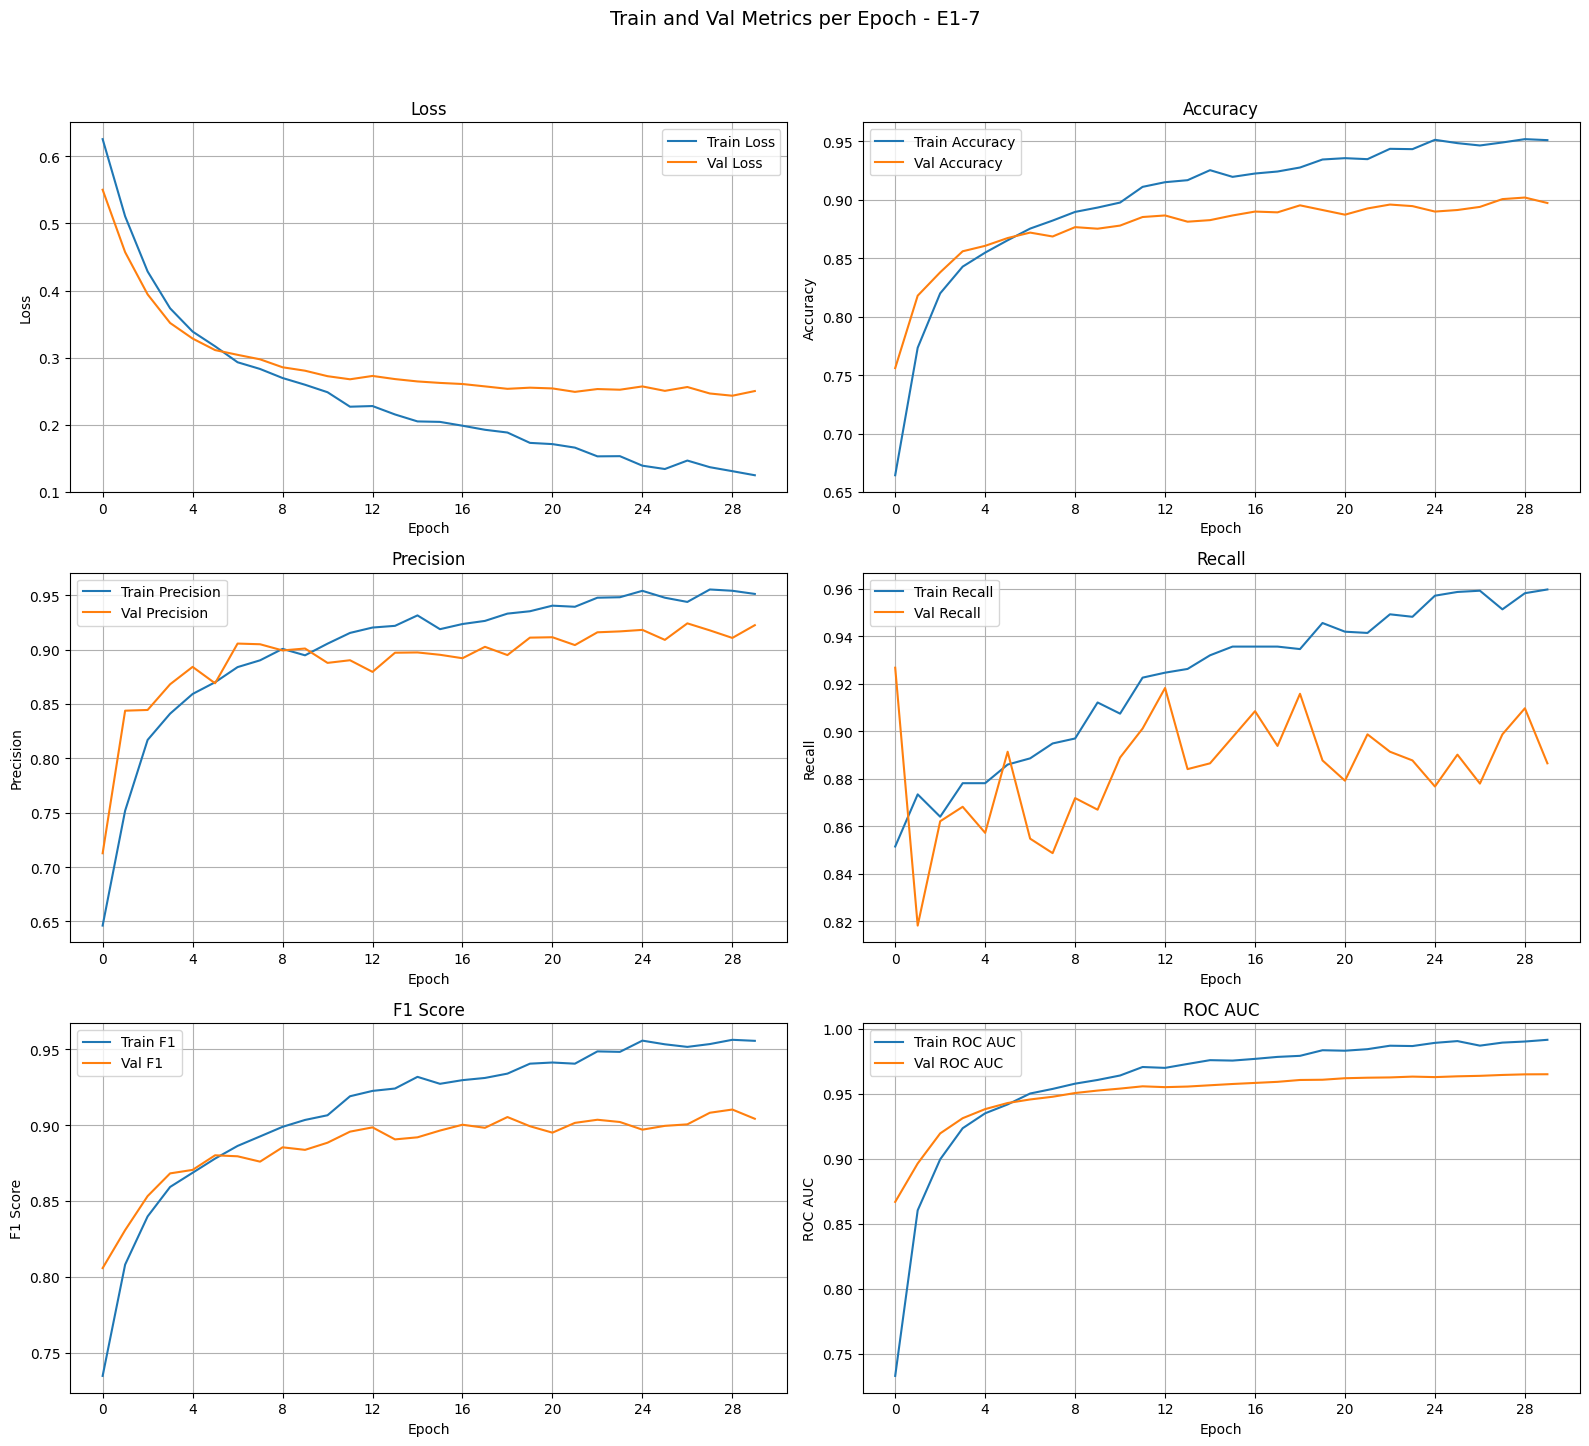

In [18]:
plot_utils.plot_train_val_metrics(df_metrics, exp_code=EXP_CODE, save_path=SAVE_FILENAME+".png")

In [19]:
df_train_conf_matrix = df_metrics['train_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
df_val_conf_matrix = df_metrics['val_conf_matrix'].apply(lambda x: pd.Series([x['tn'], x['fp'], x['fn'], x['tp']]))
#df_metrics[['val_tn', 'val_fp', 'val_fn', 'val_tp']]
df_train_conf_matrix.columns = ['train_tn', 'train_fp', 'train_fn', 'train_tp']
df_val_conf_matrix.columns = ['val_tn', 'val_fp', 'val_fn', 'val_tp']



In [20]:
df_train_conf_matrix.describe()

,train_tn,train_fp,train_fn,train_tp
count,30.000000,30.000000,30.000000,30.000000
mean,1390.400000,198.600000,149.833333,1761.166667
std,164.481128,164.481128,61.280634,61.280634
min,698.000000,85.000000,77.000000,1627.000000
25%,1379.500000,110.250000,100.250000,1711.000000
50%,1440.000000,149.000000,127.500000,1783.500000
75%,1478.750000,209.500000,200.000000,1810.750000
max,1504.000000,891.000000,284.000000,1834.000000


In [21]:
df_val_conf_matrix.describe()

,val_tn,val_fp,val_fn,val_tp
count,30.000000,30.000000,30.000000,30.000000
mean,590.433333,90.566667,94.366667,724.633333
std,44.337019,44.337019,18.574145,18.574145
min,375.000000,59.000000,60.000000,670.000000
25%,589.250000,71.500000,83.250000,715.000000
50%,601.500000,79.500000,92.000000,727.000000
75%,609.500000,91.750000,104.000000,735.750000
max,622.000000,306.000000,149.000000,759.000000


In [22]:
df_metrics.to_csv(SAVE_FILENAME+".csv", index=False)